In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("..", "training"))
if module_path not in sys.path:
    sys.path.append(module_path)

from training import VideoCNN, train_video_processor

In [2]:
import argparse
import pickle as pk
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def predict_example(model_path, example_paths: list, verbose=False):
    """
    Load a pre-trained model and predict the class for a given example
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location="cpu")

    # Create model
    num_classes = checkpoint["num_classes"]
    model = VideoCNN(num_classes=num_classes)

    # Load model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Predict
    predictions = []

    # Iterate over the list of example paths
    for example_path in example_paths:
        example_video = torch.from_numpy(train_video_processor(example_path)).unsqueeze(
            0
        )
        with torch.no_grad():
            outputs = model(example_video)
            _, predicted = torch.max(outputs, 1)
            predicted_class = predicted.item()

        # Print results
        template_id = checkpoint["unique_templates"][predicted_class]
        predictions.append((example_path, int(template_id)))

        if verbose:
            print(f"Model Path: {model_path}")
            print(f"Example Path: {example_path}")
            print(f"Predicted Label: {template_id}")

    return predictions


def predict_example_cuda(model_path, example_paths: list, verbose=False):
    """
    Load a pre-trained model and predict the classes for a list of examples.
    Utilizes GPU if available.
    """
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Create model
    num_classes = checkpoint["num_classes"]
    model = VideoCNN(num_classes=num_classes)

    # Load model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)  # Move model to the appropriate device
    model.eval()

    # Prepare predictions list
    predictions = []

    # Iterate over the list of example paths
    for example_path in example_paths:
        # Prepare example input
        example_video = torch.from_numpy(train_video_processor(example_path)).unsqueeze(
            0
        )
        example_video = example_video.to(
            device
        )  # Move input data to the appropriate device

        # Predict
        with torch.no_grad():
            outputs = model(example_video)
            _, predicted = torch.max(outputs, 1)
            predicted_class = predicted.item()

        # Map class to template ID
        template_id = checkpoint["unique_templates"][predicted_class]
        predictions.append((example_path, int(template_id)))

        # Print results if verbose
        if verbose:
            print(f"Example Path: {example_path}")
            print(f"Predicted Label: {template_id}")

    return predictions


def get_frame(video_path):
    cap = cv2.VideoCapture(video_path)

    # Check if the video was successfully opened
    if not cap.isOpened():
        raise Exception("Error: Could not open video.")
    else:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            raise Exception("Error: Video contains no frames.")

        # Calculate the middle frame index
        middle_frame_index = total_frames // 2

        # Set the position to the middle frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_index)

        # Read the middle frame
        ret, frame = cap.read()

    cap.release()
    return frame


def convert_to_cv2_color(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_and_export_images(list1, list2, output_pdf, pairs_per_page=2):
    """
    Displays two lists of images side by side and exports them to a PDF.

    Parameters:
    - list1: List of images as NumPy arrays (first column).
    - list2: List of images as NumPy arrays (second column).
    - output_pdf: Path for the output PDF file.
    - pairs_per_page: Number of image pairs to display per page.
    """
    # Ensure both lists are of the same length
    max_len = max(len(list1), len(list2))
    list1.extend([np.zeros_like(list1[0])] * (max_len - len(list1)))
    list2.extend([np.zeros_like(list2[0])] * (max_len - len(list2)))

    # Create a PDF file
    with PdfPages(output_pdf) as pdf:
        for i in range(0, len(list1), pairs_per_page):
            fig, axes = plt.subplots(
                pairs_per_page, 2, figsize=(10, 5 * pairs_per_page)
            )

            for j in range(pairs_per_page):
                if i + j < len(list1):
                    # Display the first image
                    axes[j, 0].imshow(
                        convert_to_cv2_color(list1[i + j]),
                        cmap=plt.cm.Spectral if list1[i + j].ndim == 2 else None,
                    )
                    axes[j, 0].axis("off")

                    # Display the second image
                    axes[j, 1].imshow(
                        convert_to_cv2_color(list2[i + j]),
                        cmap=plt.cm.Spectral if list2[i + j].ndim == 2 else None,
                    )
                    axes[j, 1].axis("off")
                else:
                    # Turn off unused subplots
                    axes[j, 0].axis("off")
                    axes[j, 1].axis("off")

            # Adjust layout and add the figure to the PDF
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

In [4]:
examples = {}

with open("../training/data/data_sampled_w_duplications_shuffled.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

for i, y in enumerate(Y_data):
    if y in examples:
        continue

    examples[y] = X_data[i]

In [5]:
%%time
model = "../training/outputs/save_models/VideoCNN1_checkpoint_epoch20_augmented.pth"
# exps = random.choices(X_data, k=1)
# predict_example_cuda(model, exps)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 μs


In [6]:
reddit_path = "/d/gifs"
reddit_data = os.listdir(reddit_path)
reddit_data = [os.path.join(reddit_path, x) for x in reddit_data]

In [7]:
samples = random.sample(reddit_data, 10)

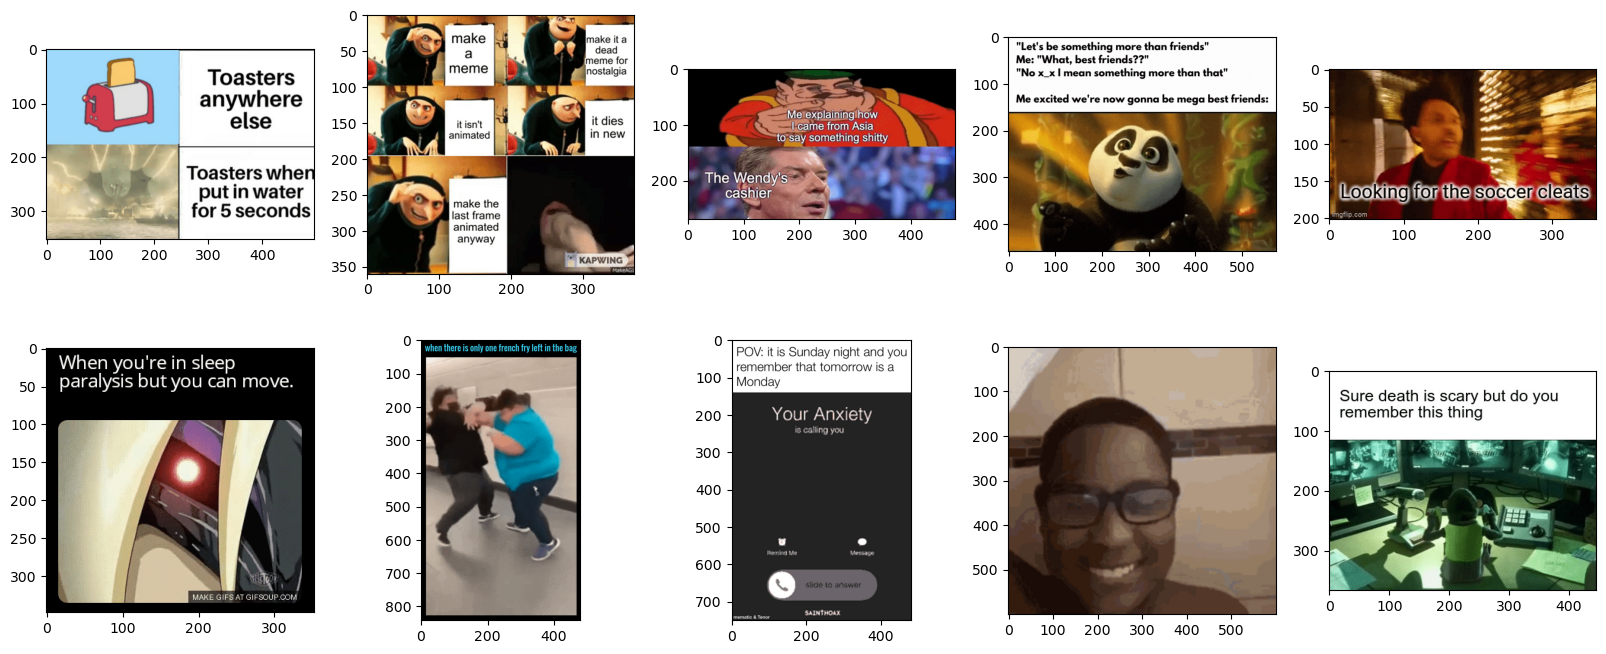

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flat):
    image = get_frame(samples[i])
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(rgb, cmap = plt.cm.Spectral)
    ax.imshow(rgb, cmap=plt.cm.Spectral)

plt.show()

/tmp/ipykernel_6998/202618181.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cpu")


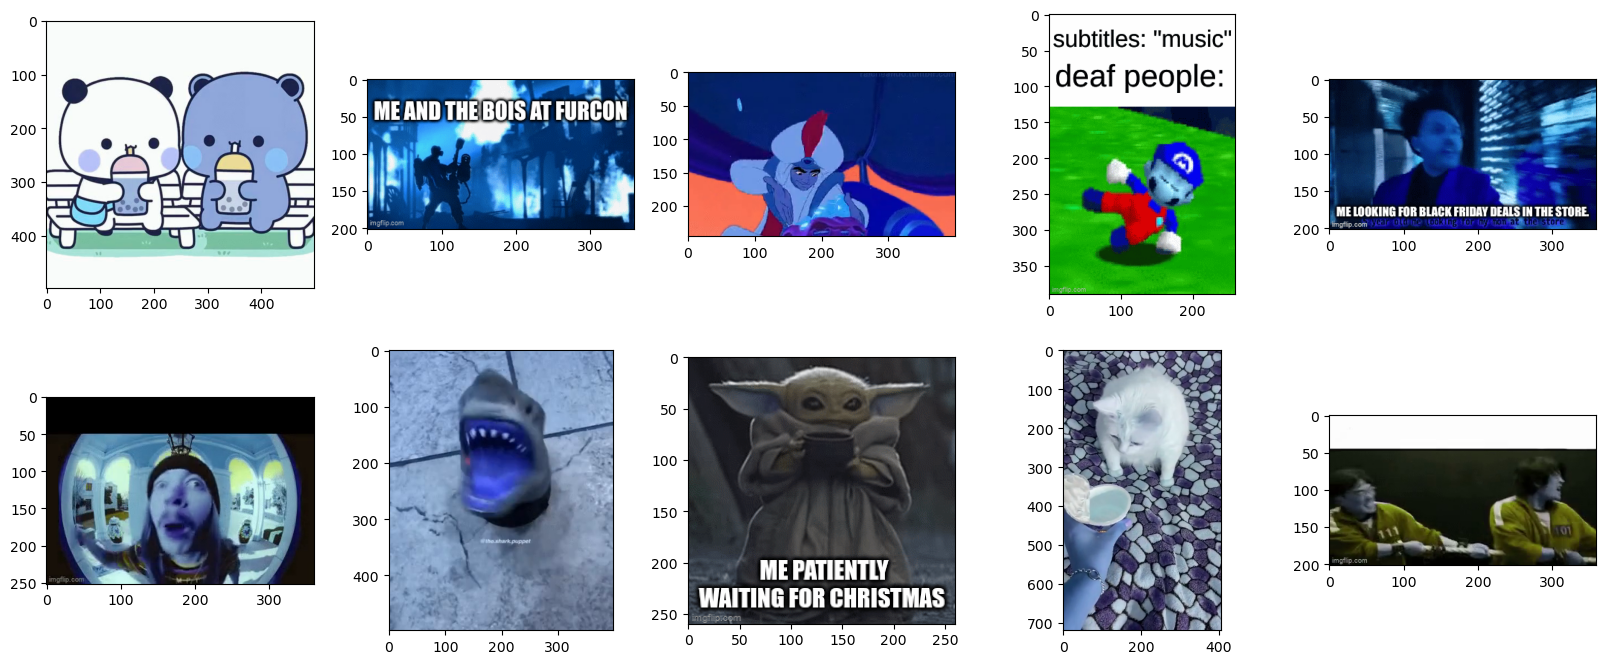

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
predictions = predict_example(model, samples)

for i, ax in enumerate(axs.flat):
    prediction = predictions[i][1]
    predict_meme = examples[prediction]
    image = get_frame(predict_meme)
    ax.imshow(image)

plt.show()

In [16]:
# Export pdf

pdf_samples = random.sample(reddit_data, 100)
og_images = [get_frame(s) for s in pdf_samples]

predictions = predict_example(model, pdf_samples)
predict_images = [get_frame(examples[p[1]]) if p[1] != 0 else None for p in predictions]

/tmp/ipykernel_6998/202618181.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cpu")


In [17]:
display_and_export_images(
    og_images, predict_images, "./outputs/reddit_test.pdf", pairs_per_page=12
)

In [12]:
len(predictions)

100

In [13]:
samples[1]

'/d/gifs/bbo9mh.gif'